In [28]:

# usual imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline
import datetime as dt
from sklearn import preprocessing
pd.set_option('display.max_columns', None)

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image
from subprocess import call
import matplotlib.pyplot as plt

# stats tests 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn import datasets


In [29]:
#read the data
data = pd.read_csv("KaggleV2-May-2016.csv", parse_dates=["AppointmentDay", "ScheduledDay"])
#data=dataframe.copy()

In [30]:
# This turns the No-show variable into a binary of 1 and 0, 1 means a no-show.  
data['Alvo'] = data['No-show'].apply(lambda x: 1 if x == 'Yes' else 0)

### Handicap and Gender

In [31]:
data['Handcap'].value_counts()

0    108286
1      2042
2       183
3        13
4         3
Name: Handcap, dtype: int64

In [32]:
data.shape

(110527, 15)

In [33]:
# binarizing handicap and Gender
data['handicap']= data['Handcap'].apply(lambda x: 0 if x==0 else 1)
data['Gender'] = data['Gender'].apply(lambda x: 1 if x == 'M' else 0)


### Date tratament

In [34]:
# Create a column that is the day of the week of the appointment 
data["week_day"] = data["AppointmentDay"].dt.weekday_name
# create a column for the time between when a patient scheduled the appointment to the appointment.
data["wait"] = (data["AppointmentDay"].dt.date - data["ScheduledDay"].dt.date).dt.days
#Saturday appointments as they are clearly outliers. 
data= data[data["week_day"] != "Saturday"]
#Drop out  all patients with wait = "0". The Decision Support System is not useful for them in real life. (this will reduce the power of the model, but it is real life)
data = data[data['wait'] > 0]



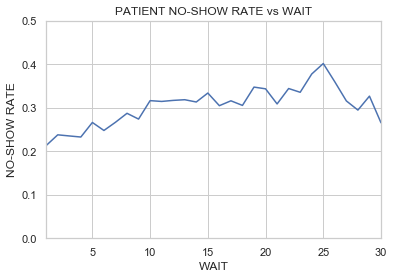

In [35]:
# create a plot of no-show rate compared to the appointment's wait
data.groupby('wait').mean().Alvo[:30].plot()
plt.title("PATIENT NO-SHOW RATE vs WAIT")
plt.ylabel("NO-SHOW RATE")
plt.xlabel("WAIT")
plt.ylim(0,.50)
plt.show()

### Age Analysis

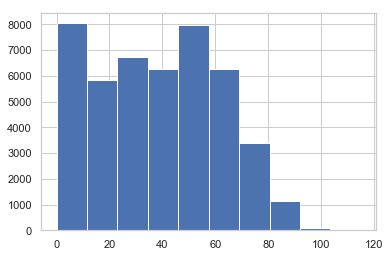

In [36]:
data.drop_duplicates('PatientId')['Age'].hist()

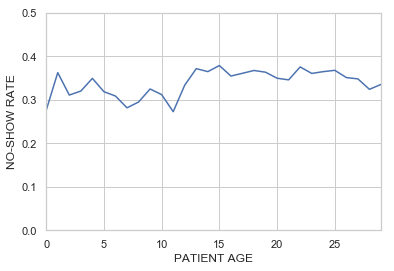

In [37]:
# create a plot of no-show rate compared to the patients age, discovering breaks to discretize it.
data.groupby('Age').mean().Alvo[:30].plot()
plt.ylabel("NO-SHOW RATE")
plt.xlabel("PATIENT AGE")
plt.ylim(0,.5)
plt.show()
#data.groupby('appointment_day')[["no_show_bi"]].mean()

In [38]:
#Discretize data for rules and decision tree in changes directions of graph.
#Recém-nascido: 0
#Criança: 1-11
#Adolescente: 12-20
#Adulto Jovem: 21-30
#Adulto Meia idade: 31-59
#Idoso: 60-
def bin_age(df):
    '''Creates a function to turn age into 6 groups of binned ages.'''
                        # bin ranges 0-3, 4-7, 8-27, 28-40, 41-60, 61 < 
    if df["Age"] <1:
        return "Recem-nascido"
    elif df["Age"] <12:
        return "Criança"
    elif df["Age"] <21:
        return "Adolecente"
    elif df["Age"] <31:
        return "Adulto Jovem"
    elif df["Age"] <60:
        return "Adulto Meia Idade"
    else:
        return "Idoso"

In [39]:
# apply binning function
data["Age_Bin"]= data.apply(bin_age, axis=1)

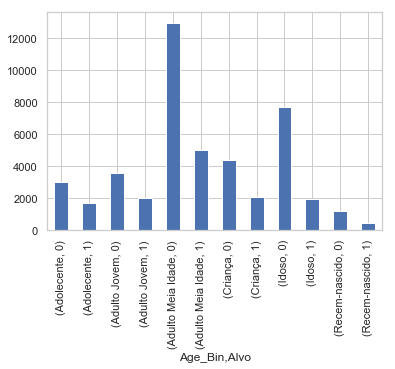

In [46]:
data.drop_duplicates('PatientId').groupby(['Age_Bin'])['Alvo'].value_counts().plot('bar')

In [114]:
df1=data.loc[:,('PatientId','Age_Bin', 'Age', 'SMS_received', 'wait','Gender', 'Alvo')]
df1.head()

,PatientId,Age_Bin,Age,SMS_received,wait,Gender,Alvo
5,95985133231274,Idoso,76,0,2,0,0
6,733688164476661,Adulto Jovem,23,0,2,0,1
7,3449833394123,Adulto Meia Idade,39,0,2,0,1
9,78124564369297,Adolecente,19,0,2,0,0
10,734536231958495,Adulto Jovem,30,0,2,0,0


In [115]:
df2 = pd.read_csv("temp.csv", parse_dates=["AppointmentDay", "ScheduledDay"])
df2=df2.drop_duplicates('PatientId')
df2=df2.loc[:,('PatientId', 'n_noshow_passed')]
df2.head()

,PatientId,n_noshow_passed
0,95985133231274,0
1,733688164476661,0
2,3449833394123,0
3,78124564369297,0
4,734536231958495,0


In [116]:
df3=pd.merge(df1,df2, on='PatientId')

In [119]:
df3=df3.loc[:,('PatientId','Age_Bin', 'Age', 'Gender', 'wait', 'SMS_received', 'Alvo')]

In [121]:
df3.to_csv("db_IN1119.csv", sep=",") 

### Zones and Neighbourhood analysis

In [22]:
# adding another column with zones neighbourhoods
dataframeZone={}
dataframeZone=pd.read_csv( "regiao_adm.csv", delimiter="," )
dataframeZone["Neighbourhood"]=dataframeZone["Neighbourhood"].apply(lambda x: x.upper().strip())
data['Neighbourhood']=data['Neighbourhood'].apply(lambda x: x.upper().strip())
data=pd.merge(data, dataframeZone, on='Neighbourhood', how='left')


In [23]:
#missing zones
data['Adm_Zone'].fillna('others', inplace=True)

In [24]:
# Order the zones by the mean income - data of 2010 (http://legado.vitoria.es.gov.br/regionais/dados_regiao/regiao_9/regiao9d.asp)
def order_zone(df):
    col='Adm_Zone'
    if df[col] =="VII – São Pedro":
        return 1
    elif df[col] == "II - Santo Antônio":
        return 2
    elif df[col] == "IV – Maruípe":
        return 3
    elif df[col] =="VI – Continente":
        return 4
    elif df[col] =="III - Bento Ferreira/Jucutuquara":
        return 5
    elif df[col] =="I – Centro":
        return 6
    else:
        return 3


In [25]:
data["order_zone"]= data.apply(order_zone, axis=1)

In [26]:
#frequency
data.drop_duplicates('PatientId')['order_zone'].value_counts()

3    13024
4    10314
1     6743
2     6514
5     5398
6     3825
Name: order_zone, dtype: int64

### Behavior Patient - Temporal Features

In [27]:
#previous number of no-shows
def behavior_noshow(row):
        appointment_passed = data.loc[(data.PatientId == row.PatientId) & (data.AppointmentDay < row.AppointmentDay), 'Alvo']
        noshow_passed = data.loc[(data.PatientId == row.PatientId) & (data.AppointmentDay < row.AppointmentDay), 'Alvo']

        #print(consultas_passado)
        row["n_appoint_passed"] = len(appointment_passed)
        row["n_noshow_passed"] = noshow_passed.sum()
        return row

In [830]:
#apllyng
data=data.apply(behavior_noshow, axis=1)


In [831]:
#the last process is so long. Then, here a good commit point, to save time.
#data.to_csv("temp.csv", sep=",") 

In [5]:
data = pd.read_csv("temp.csv", parse_dates=["AppointmentDay", "ScheduledDay"])


/Users/rogerio/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Creating other behaviors features. 

stat_last_app: if the patient no-show  in her last day appointment. If the patient has various appointments in the same day, only one show-up it's necessary to be marked as a show-up patient.

stat_last_first: If her first time


In [6]:
#if the patient have at least one show up in the present day.
data = data.sort_values(by = ['AppointmentDay', 'ScheduledDay'], axis = 0)
data['sum'] = data.groupby(['PatientId', 'AppointmentDay'])['Alvo'].transform('sum')
data['size'] = data.groupby(['PatientId', 'AppointmentDay'])['Alvo'].transform('size')
data.loc[(data['sum'] != data['size']) | (data['sum'] == 0), 'present'] = 0
data.loc[(data['sum'] == data['size']), 'present'] = 1 

#Take the last status
data['stat_last'] = data.groupby(['PatientId'])['present'].apply(lambda x : x.shift(1))
data['stat_last_app'] = data['stat_last'].fillna(0)
data['stat_last']= data['stat_last'].fillna("First")
data=pd.get_dummies(data=data, columns=['stat_last'])

#drop unnecessary features
data.drop(['stat_last_0.0','stat_last_1.0', 'sum', 'size', 'present'],inplace=True, axis=1)

### Transform the dataset to grain appoitnments of patient per day. It's necessary because for the available features on dataset is better to discover  if the patient will be present on her appointment day, whether or not he has one ore more appointments that day. 

we have lower level of information on day per patient. Only "Appointment", "No-show"s and "Wait". We already have extracted "Number of Appointments" and "Number of no-show". Now we will extract the mean of wait to each appointment on the same day to one patient

In [7]:
data['wait'] = data.groupby(['PatientId', 'AppointmentDay'])['wait'].transform('mean')
data = data.drop_duplicates(['PatientId', 'AppointmentDay'])


In [8]:
#how is the frequency of this feature?
data["n_appoint_passed"].value_counts()

0     46011
1     13049
2      4881
3      2017
4      1053
5       589
6       376
7       250
8       176
9       152
10       89
11       68
12       49
13       31
14       17
15       14
16       12
18        6
17        5
19        4
28        1
20        1
21        1
22        1
23        1
24        1
25        1
27        1
29        1
Name: n_appoint_passed, dtype: int64

In [9]:
#Discretize number of appoinment by frequency. Can be good to Rules.
def bin_no_appointment_passed(df):
    col="n_appoint_passed"
    if df[col]  <1:
        return 0
    elif df[col] <2:
        return 1
    elif df[col] <3:
        return 2
    elif df[col] <4:
        return 3
    elif df[col] <5:
        return 4
    else: 
        return 5

In [10]:
#applyng
data["n_appoint_passed_bin"]= data.apply(bin_no_appointment_passed, axis=1)

In [11]:
#and now?
data['n_appoint_passed_bin'].value_counts()

0    46011
1    13049
2     4881
3     2017
5     1847
4     1053
Name: n_appoint_passed_bin, dtype: int64

In [12]:
# How many people has 0 no-show and are in your first appointment?
print(((data['n_noshow_passed']==0) & (data['stat_last_First']==1)).sum(),'out of',(data['n_noshow_passed'] ==0).sum(),'patients who never failed, are on your first appointment')

49552 out of 60267 patients who never failed, are on your first appointment


In [13]:
#how is the frequency of this feature?
data['n_noshow_passed'].value_counts()

0     60267
1      6688
2      1322
3       368
4       137
5        46
6        14
7         7
8         5
10        2
9         2
Name: n_noshow_passed, dtype: int64

In [14]:
#Discretize by frequency keeping the order. Can be good to rules.
def bin_no_show_passed(df):
    col="n_noshow_passed"
    if df[col]  <1:
        return 0
    elif df[col] <2:
        return 1
    elif df[col] <3:
        return 2
    elif df[col] <4:
        return 3
    elif df[col] <5:
        return 4
    else: 
        return 5

In [15]:
#applyng
data["n_noshow_passed_bin"]= data.apply(bin_no_show_passed, axis=1)

In [16]:
#and now?
data["n_noshow_passed_bin"].value_counts()

0    60267
1     6688
2     1322
3      368
4      137
5       76
Name: n_noshow_passed_bin, dtype: int64

In [17]:
#All features avaliable to play
data.columns


Index(['Unnamed: 0', 'PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show', 'Alvo',
       'handicap', 'week_day', 'wait', 'age_binned', 'Adm_Zone', 'order_zone',
       'n_appoint_passed', 'n_noshow_passed', 'stat_last_app',
       'stat_last_First', 'n_appoint_passed_bin', 'n_noshow_passed_bin'],
      dtype='object')

In [18]:
#missing?
data.isnull().sum()

Unnamed: 0              0
PatientId               0
AppointmentID           0
Gender                  0
ScheduledDay            0
AppointmentDay          0
Age                     0
Neighbourhood           0
Scholarship             0
Hipertension            0
Diabetes                0
Alcoholism              0
Handcap                 0
SMS_received            0
No-show                 0
Alvo                    0
handicap                0
week_day                0
wait                    0
age_binned              0
Adm_Zone                0
order_zone              0
n_appoint_passed        0
n_noshow_passed         0
stat_last_app           0
stat_last_First         0
n_appoint_passed_bin    0
n_noshow_passed_bin     0
dtype: int64

In [19]:
#category features
categorical =['age_binned', "Adm_Zone", "week_day"]
#numeric features 
numerical=['wait','n_noshow_passed', "n_appoint_passed", "order_zone"]

#binary features - commom in all sets
binary=["Gender","Scholarship", "Hipertension","Diabetes","Alcoholism","handicap","SMS_received", 'stat_last_First','stat_last_app',"Alvo"]

#to split train-test
date_to_split = ["AppointmentDay"]

#Conjunto 1
conjunto1 = data[categorical + numerical + binary + date_to_split]
conjunto1 = pd.get_dummies(conjunto1, columns=(categorical))
conjunto1=conjunto1.reset_index()
##escaling to conjunto 1
#scaler = preprocessing.MinMaxScaler()
#scaled_df = scaler.fit_transform(conjunto1)
#scaled_df = pd.DataFrame(scaled_df, columns=[numerical])

n_test = conjunto1[numerical]
x = n_test.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
n_test = pd.DataFrame(x_scaled, columns=numerical)
l_test = conjunto1.drop(numerical, axis=1)
conjunto1 = pd.concat([n_test, l_test], axis=1)
conjunto1 = conjunto1.drop(['index'], axis=1)

#Conjunto 2




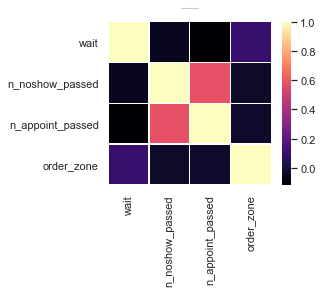

In [302]:
#correlatrion numeric features
colormap = plt.cm.magma
plt.figure(figsize=(4,3))
plt.title('Pearson correlation of continuous features', y=1.05, size=1)
sns.heatmap(data[numerical].corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white')

In [21]:
#better to ML models
conjunto1.columns

Index(['wait', 'n_noshow_passed', 'n_appoint_passed', 'order_zone', 'Gender',
       'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'handicap',
       'SMS_received', 'stat_last_First', 'stat_last_app', 'Alvo',
       'AppointmentDay', 'age_binned_0', 'age_binned_1-4', 'age_binned_10-14',
       'age_binned_15ormore', 'age_binned_5-9', 'Adm_Zone_I – Centro',
       'Adm_Zone_II - Santo Antônio',
       'Adm_Zone_III - Bento Ferreira/Jucutuquara', 'Adm_Zone_IV – Maruípe',
       'Adm_Zone_V – Praia do Canto', 'Adm_Zone_VI – Continente',
       'Adm_Zone_VII – São Pedro', 'Adm_Zone_others', 'week_day_Friday',
       'week_day_Monday', 'week_day_Thursday', 'week_day_Tuesday',
       'week_day_Wednesday'],
      dtype='object')

In [22]:
#rules and decision Tree
numerical_1=['wait','n_noshow_passed_bin', "n_appoint_passed_bin", "order_zone"]
conjunto2 = data[categorical + numerical_1 +binary + date_to_split]

In [23]:
conjunto2[binary] = conjunto2[binary].astype(str) 
conjunto2.dtypes

/Users/rogerio/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


age_binned                           object
Adm_Zone                             object
week_day                             object
wait                                float64
n_noshow_passed_bin                   int64
n_appoint_passed_bin                  int64
order_zone                            int64
Gender                               object
Scholarship                          object
Hipertension                         object
Diabetes                             object
Alcoholism                           object
handicap                             object
SMS_received                         object
stat_last_First                      object
stat_last_app                        object
Alvo                                 object
AppointmentDay          datetime64[ns, UTC]
dtype: object

### Train and Test

to undestand the rate of no-show on the time, and choose a good date do split.

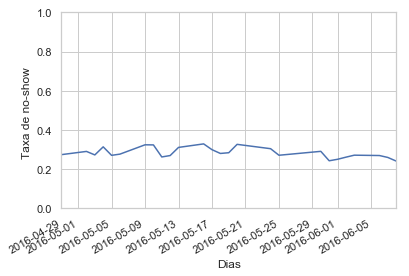

In [299]:
data.groupby('AppointmentDay').mean().Alvo[:30].plot()
plt.ylabel("Taxa de no-show ")
plt.xlabel("Dias")
plt.ylim(0,1)
plt.show()

### the rate is continuos, We will use the last week to the test

In [25]:
conjunto1_train = conjunto1[(conjunto1.AppointmentDay< '2016-05-29')& (conjunto1.AppointmentDay>='2016-04-29')]
conjunto1_test = conjunto1[conjunto1.AppointmentDay >  '2016-05-29']

conjunto2_train = conjunto2[(conjunto2.AppointmentDay< '2016-05-29')& (conjunto2.AppointmentDay>='2016-04-29')]
conjunto2_test = conjunto2[conjunto2.AppointmentDay >  '2016-05-29']

In [26]:
#now, excluding the date
conjunto1_train.drop('AppointmentDay', inplace=True, axis=1)
conjunto1_test.drop('AppointmentDay', inplace=True, axis=1)

conjunto2_train.drop('AppointmentDay', inplace=True, axis=1)
conjunto2_test.drop('AppointmentDay', inplace=True, axis=1)

/Users/rogerio/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [27]:
print("Rate Alvo  on Train:", (conjunto1_train['Alvo']==1).sum()/(conjunto1_train['Alvo'].count()))
print("Rate Alvo on Test:",(conjunto1_test['Alvo']==1).sum()/(conjunto1_test['Alvo'].count()))


Rate Alvo  on Train: 0.29345058518946443
Rate Alvo on Test: 0.2605216762352516


In [28]:
#conjunto1 - ML models
conjunto1_train.to_csv('RL_train.csv', sep=',')
conjunto1_test.to_csv('RL_test.csv', sep=',')

In [29]:
#conjunto2 Decision Tree and Rules Induction
conjunto2_train.to_csv('DT_RI_train.csv', sep=',')
conjunto2_test.to_csv('DT_RI_test.csv', sep=',')

In [30]:
conjunto1_train.head()

,wait,n_noshow_passed,n_appoint_passed,order_zone,Gender,Scholarship,Hipertension,Diabetes,Alcoholism,handicap,SMS_received,stat_last_First,stat_last_app,Alvo,age_binned_0,age_binned_1-4,age_binned_10-14,age_binned_15ormore,age_binned_5-9,Adm_Zone_I – Centro,Adm_Zone_II - Santo Antônio,Adm_Zone_III - Bento Ferreira/Jucutuquara,Adm_Zone_IV – Maruípe,Adm_Zone_V – Praia do Canto,Adm_Zone_VI – Continente,Adm_Zone_VII – São Pedro,Adm_Zone_others,week_day_Friday,week_day_Monday,week_day_Thursday,week_day_Tuesday,week_day_Wednesday
0,0.640449,0.0,0.0,0.0,0,0,1,1,0,1,1,1,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,0.640449,0.0,0.0,0.0,0,0,1,0,0,0,1,1,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
2,0.606742,0.0,0.0,0.8,0,0,0,0,0,0,1,1,0.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,0.606742,0.0,0.0,0.8,0,0,1,1,0,0,1,1,0.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,0.606742,0.0,0.0,0.8,0,0,0,0,0,0,1,1,0.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [31]:
conjunto2_train.head()

,age_binned,Adm_Zone,week_day,wait,n_noshow_passed_bin,n_appoint_passed_bin,order_zone,Gender,Scholarship,Hipertension,Diabetes,Alcoholism,handicap,SMS_received,stat_last_First,stat_last_app,Alvo
641,15ormore,VII – São Pedro,Friday,115.0,0,0,1,0,0,1,1,0,1,1,1,0.0,0
640,15ormore,VII – São Pedro,Friday,115.0,0,0,1,0,0,1,0,0,0,1,1,0.0,0
646,15ormore,III - Bento Ferreira/Jucutuquara,Friday,109.0,0,0,5,0,0,0,0,0,0,1,1,0.0,0
644,15ormore,III - Bento Ferreira/Jucutuquara,Friday,109.0,0,0,5,0,0,1,1,0,0,1,1,0.0,0
645,15ormore,III - Bento Ferreira/Jucutuquara,Friday,109.0,0,0,5,0,0,0,0,0,0,1,1,0.0,0


In [32]:
#arvore
conjunto2_train()

In [937]:
X_train = conjunto2_train.drop('Alvo', axis=1)
y_train = conjunto2_train['Alvo']

X_test = conjunto2_test.drop('Alvo', axis=1)
y_test = conjunto2_test['Alvo']

In [ ]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

In [ ]:
(SMS_received = 0) and (n_noshow_passed_bin >= 1) and (wait >= 14) => Alvo=1 (730.0/343.0)
(SMS_received = 0) and (wait >= 23) and (age_binned = 1-4) => Alvo=1 (275.0/134.0)

n_noshow_passed_bin <= 1 AND age_binned = 0: 0 (510.0/177.0)
wait <= 9: 0 (24813.0/6214.0)
stat_last_app = 0.0 AND
Hipertension = 1: 0 (3560.0/994.0)
    
    stat_last_app = 0.0 AND
SMS_received = 1: 0 (3001.0/1044.0)

    
n_noshow_passed_bin <= 1 AND
age_binned = 5-9: 0 (786.0/325.0)

In [312]:
df=conjunto2_test

In [188]:

#df[df.n_appoint_passed_bin==0]['Alvo'].value_counts()


In [ ]:
wait <= 9 AND
n_appoint_passed <= 3 AND
Scholarship = 0: 0 (22668.0/5628.0)

    
wait <= 9: 0  (cobertura: 0,45 , confianca: 0,23 , lift: 0.88 )
wait > 9 (cobertura: 0,55 , confianca: 0,29 , lift: 1.10 )
|   stat_last_app = 0.0: 0 (cobertura: 0,49 , confianca: 0,28 , lift: 1.05 )
|   stat_last_app = 1.0 (cobertura: 0.05 , confianca: 0,40 , lift: 1.5 )
|   |   SMS_received = 1: 0 (cobertura: 0.046, confianca: 0,40, lift: 1.5 )
|   |   SMS_received = 0 (cobertura:0.008 , confianca: 0.38, lift:  1.45 )
|   |   |  
SMS = 0,Wait >= 23, Idade = 1 a 4

In [316]:
a = df.loc[regra]
cobertura = a.shape[0]/conjunto2_test.shape[0]
confianca= a[a.Alvo=='1'].shape[0]/a.shape[0]
print("cobertura", cobertura)
print("confianca", confianca)
print('lift', confianca/0.26)

cobertura 0.5476244292753493
confianca 0.2867756315007429
lift 1.1029831980797804


In [289]:
a.shape[0]

8

In [155]:
# First 
alvo=full['Alvo']=='1' 
##
frame1=full.loc[full['wait']>9] 
criterio1=full['wait']>9
cobertura1 =frame1.shape[0]/full.shape[0]*100
confianca1=full[criterio1 & alvo].shape[0]/frame1.shape[0]
print('wait > 9:', frame1.shape[0] ,'coverage:', round(cobertura1,1), 'confidence:',round(confianca1,3)*100, 'lift:' ,round(confianca1/0.29,2) )

##
frame1a=full.loc[full['wait']<=9] 
criterio1a=full['wait']<=9
cobertura1a =frame1a.shape[0]/full.shape[0]*100
confianca1a=full[criterio1a & alvo].shape[0]/frame1a.shape[0]
print('wait <= 9:', frame1a.shape[0] ,'coverage:', round(cobertura1a,1), 'confidence:',round(confianca1a,3)*100, 'lift:' ,round(confianca1a/0.29,2) )




wait > 9: 21924 coverage: 46.9 confidence: 34.2 lift: 1.18
wait <= 9: 24813 coverage: 53.1 confidence: 25.0 lift: 0.86


In [167]:
frame2=frame1.loc[frame1['stat_last_app']=='0.0'] 
criterio2=frame1['stat_last_app']=='0.0'
cobertura2=frame2.shape[0]/full.shape[0]*100
confianca2=frame1[criterio2 & alvo].shape[0]/frame2.shape[0]
print('wait > 9 and stat_last_app = 0 :', frame2.shape[0] ,'covarege:', round(cobertura2,1), 'confidence:',round(confianca2,3)*100, 'lift:' ,round(confianca2/0.29,2) )

frame2a=frame1.loc[frame1['stat_last_app']=='1.0'] 
criterio2a=frame1['stat_last_app']=='1.0'
cobertura2a=frame2a.shape[0]/full.shape[0]*100
confianca2a=frame1[criterio2a & alvo].shape[0]/frame2a.shape[0]
print('wait > 9 and stat_last_app = 1 :', frame2a.shape[0] ,'covarege:', round(cobertura2a,1), 'confidence:',round(confianca2a,3)*100, 'lift:' ,round(confianca2a/0.29,2) )


wait > 9 and stat_last_app = 0 : 20954 covarege: 44.8 confidence: 33.5 lift: 1.15
wait > 9 and stat_last_app = 1 : 970 covarege: 2.1 confidence: 50.1 lift: 1.73


/Users/rogerio/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/rogerio/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


In [169]:
frame3=frame2a.loc[frame2a['SMS_received']=='1'] #moradia estudantil
criterio3=frame2a['SMS_received']=='1'
cobertura3=frame3.shape[0]/full.shape[0]*100
confianca3=frame2a[criterio3 & alvo].shape[0]/frame3.shape[0]
print('wait > 9, stat_last_app =1, sms_received = 1:', frame3.shape[0] ,'tx:', round(cobertura3,1), 'confianca:',round(confianca3,3)*100, 'lift:' ,round(confianca3/0.25,2) )
####
frame3=frame2a.loc[frame2a['SMS_received']=='0'] #moradia estudantil
criterio3=frame2a['SMS_received']=='0'
cobertura3=frame3.shape[0]/full.shape[0]*100
confianca3=frame2a[criterio3 & alvo].shape[0]/frame3.shape[0]
print('wait > 9, stat_last_app =1, sms_received = 0:', frame3.shape[0] ,'tx:', round(cobertura3,1), 'confianca:',round(confianca3,3)*100, 'lift:' ,round(confianca3/0.25,2) )
####

wait > 9, stat_last_app =1, sms_received = 1: 346 tx: 0.7 confianca: 48.3 lift: 1.93
wait > 9, stat_last_app =1, sms_received = 0: 624 tx: 1.3 confianca: 51.1 lift: 2.04


/Users/rogerio/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/rogerio/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


In [147]:
df.loc[(df.wait > 9) &  (df.stat_last_app == '1.0') & (df.SMS_received == '1'), "Alvo"].value_counts()


0    179
1    167
Name: Alvo, dtype: int64